In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/GCN

/content/gdrive/MyDrive/Colab Notebooks/GCN


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot, Dropout, Dense, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.utils import model_to_dot
from IPython.display import SVG

In [5]:
# read movielens .dat file
df_raw = [i.strip().split('::') for i in open('ml-1m-2/ratings.dat').readlines()]
df = pd.DataFrame(df_raw, columns=['userID', 'itemID', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)
df['rating'] = df['rating'].astype(int)
df['userID'] = df['userID'].astype(int)
df['itemID'] = df['itemID'].astype(int)
df

,userID,itemID,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [6]:
num_users = len(df['userID'].unique())
num_prods = len(df['itemID'].unique())
train, test = train_test_split(df, test_size=0.15, random_state=14, stratify=df['userID'])

print('Number of products', num_prods)
print('Number of reviewers', num_users)

Number of products 3706
Number of reviewers 6040


In [ ]:
latent_dim = 10

# Input and MLP embeddings
prod_input = Input(shape=(1,),name='prod-input')
prod_embedding_mlp = Embedding(num_prods + 1, latent_dim, name='prod-embedding-mlp')(prod_input)
prod_vec_mlp = Flatten(name='prod-flatten-mlp')(prod_embedding_mlp)

user_input = Input(shape=(1,),name='user-input')
user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='user-flatten-mlp')(user_embedding_mlp)

# MF embeddings
prod_embedding_mf = Embedding(num_prods + 1, latent_dim, name='prod-embedding-mf')(prod_input)
prod_vec_mf = Flatten(name='prod-flatten-mf')(prod_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='user-flatten-mf')(user_embedding_mf)


# MLP layers
concat = Concatenate(axis=1)([prod_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)


# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = Dot(axes=1)([prod_vec_mf, user_vec_mf])
combine_mlp_mf = Concatenate(axis=1)([pred_mf, pred_mlp])


# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, prod_input], result)
# Keras adam optimizer uses 2 different regularization parameters, exponential decay rates beta_1 and beta_2 for 1st and 2nd moment estimates
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prod-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 prod-embedding-mlp (Embedding)  (None, 1, 10)       16830       ['prod-input[0][0]']             
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       9440        ['user-input[0][0]']             
                                                                                            

Epoch 1/100
84/84 [==============================] - 3s 12ms/step - loss: 1.5028 - mean_absolute_error: 1.5028 - mean_absolute_percentage_error: 49.4821
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 1.0963 - mean_absolute_error: 1.0963 - mean_absolute_percentage_error: 42.0876
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 1.0219 - mean_absolute_error: 1.0219 - mean_absolute_percentage_error: 40.0783
Epoch 4/100
84/84 [==============================] - 1s 12ms/step - loss: 0.9787 - mean_absolute_error: 0.9787 - mean_absolute_percentage_error: 38.8369
Epoch 5/100
84/84 [==============================] - 1s 12ms/step - loss: 0.9465 - mean_absolute_error: 0.9465 - mean_absolute_percentage_error: 37.8010
Epoch 6/100
84/84 [==============================] - 1s 12ms/step - loss: 0.9249 - mean_absolute_error: 0.9249 - mean_absolute_percentage_error: 36.6200
Epoch 7/100
84/84 [==============================] - 1s 7ms/step - loss: 0.9030 - 

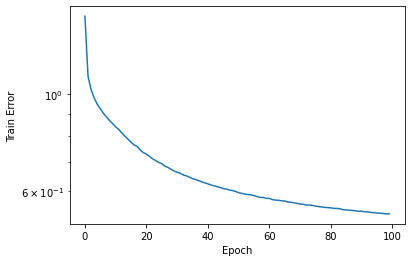

Took 83.58876490592957s


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

start = time.time()
history = model.fit([np.array(train['userID']), np.array(train['itemID'])], np.array(train['rating']), epochs=100, batch_size=1024)
stop = time.time()
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()
print(f'Took {stop-start}s')

In [ ]:
model.save('neuralCF_100k_lr0025')
# model = keras.models.load_model('neuralCF_100k_lr0025')

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = test['rating'].to_numpy()
y_hat = np.round(model.predict([test['userID'].to_numpy(), test['itemID'].to_numpy()]), decimals=2)
mean_squared_error(y_true, y_hat, squared=False)

469/469 [==============================] - 1s 2ms/step


0.9956902406874427

In [ ]:
# test['model_rating'] = y_hat
# test

,userID,itemID,rating,model_rating
192121,1183,2662,4,5.64
672056,4040,1645,2,3.64
852273,5112,2527,4,3.07
415374,2501,2502,3,5.41
161908,1033,1250,4,4.77
...,...,...,...,...
13152,102,3512,1,0.00
727519,4352,2193,3,3.90
103794,690,2640,4,3.63
459233,2826,1966,4,3.03


In [ ]:
def return_unrated(train_data, userID, user_col='userID', item_col='itemID'):
    unique_items = train_data[item_col].unique()
    user_rated_items = train_data.loc[train_data[user_col]==userID, item_col].unique()

    return unique_items[~np.in1d(unique_items, user_rated_items)]

def hit_ratio(df, test_data, model, k=5):
    unique_test_users = test_data['userID'].unique()
    hr_k = 0
    user_count = 0
    for uid in unique_test_users:
        user_not_rated = return_unrated(df, uid)
        user_rel_items = test_data.loc[test_data['userID']==uid, 'itemID'].values
        
        predicted = model.predict([np.full(len(user_not_rated), uid), user_not_rated])
        item_predictions = pd.DataFrame([i for j in predicted for i in j], index=user_not_rated, columns=['predicted_rating']).sort_values(by='predicted_rating', ascending=False)
        item_predictions = item_predictions.reset_index()
        item_predictions.columns = ['itemID', 'predicted_rating']
        sum_hits = sum(item_predictions[:k]['itemID'].isin(user_rel_items))
        if sum_hits > 0:
            hr_k += 1
        user_count +=1

    return hr_k/user_count


hr_20 = hit_ratio(train, test, model, k=20)

In [ ]:
hr_20

0.43902439024390244